In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import configs
import pandas as pd
import seaborn as sns
from utils import get_firing_field

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/Users/chingfang/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [32]:
experiment_dir = '../trained_models/02_gamma_v_ss_v2/'

# Training loss over time

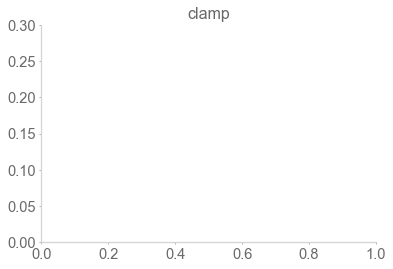

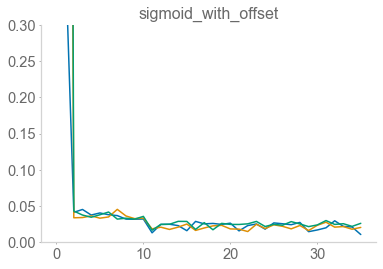

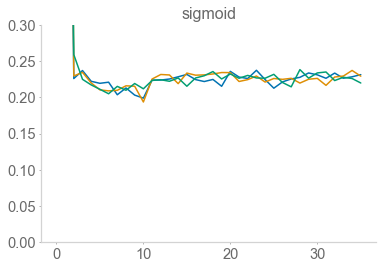

In [38]:
args = []     
gamma = 0.6
for nonlinearity in os.listdir(experiment_dir):
    if nonlinearity.startswith('.'): continue
    gamma_dir = f'{experiment_dir}{nonlinearity}/{gamma}/'                                               
    best_iter_val = np.inf                                                                               
    best_iter = None              
    plt.figure()
    for _iter in os.listdir(gamma_dir):                                                                  
        iter_dir = f'{gamma_dir}{_iter}/'                                                                
        if not os.path.isfile(iter_dir + 'net_configs.p'):                                               
            continue                                                                                     
        for file in os.listdir(iter_dir):                                                                
            if 'tfevents' not in file: continue                                                          
            tfevents_file = iter_dir + file                                                              
            event_acc = EventAccumulator(tfevents_file)                                                  
            event_acc.Reload()           
            iter_val = [                                                                                 
                x.value for x in event_acc.Scalars('loss_train')                            
                ]                         
            plt.plot(iter_val)
    plt.title(f'{nonlinearity}')
    plt.ylim(0, 0.3)
    plt.show()

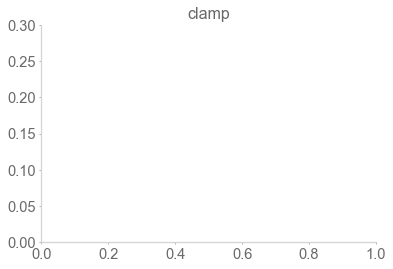

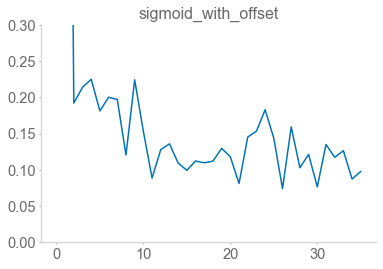

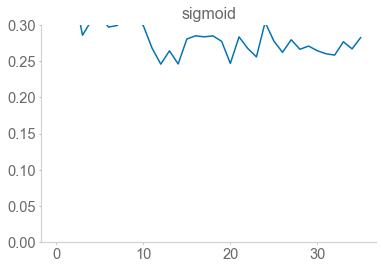

In [40]:
args = []           
gamma = 0.8
for nonlinearity in os.listdir(experiment_dir):
    if nonlinearity.startswith('.'): continue                                                                                                                                                       
    gamma_dir = f'{experiment_dir}{nonlinearity}/{gamma}/'                                               
    best_iter_val = np.inf                                                                               
    best_iter = None              
    plt.figure()
    for _iter in os.listdir(gamma_dir):                                                                  
        iter_dir = f'{gamma_dir}{_iter}/'                                                                
        if not os.path.isfile(iter_dir + 'net_configs.p'):                                               
            continue                                                                                     
        for file in os.listdir(iter_dir):                                                                
            if 'tfevents' not in file: continue                                                          
            tfevents_file = iter_dir + file                                                              
            event_acc = EventAccumulator(tfevents_file)                                                  
            event_acc.Reload()           
            iter_val = [                                                                                 
                x.value for x in event_acc.Scalars('loss_train')                            
                ]                         
            plt.plot(iter_val)
    plt.title(f'{nonlinearity}')
    plt.ylim(0, 0.3)
    plt.show()                      

# Test Error

In [9]:
def run(exp_dir):
    """
    Plots example M matrices for unbiased and forward-biased 1D walks.
    """
    
    num_states = 20

    # Test datasets
    dsets = [
        inputs.Sim1DWalk(num_steps=6000, num_states=num_states, left_right_stay_prob=[1,1,1]),
        inputs.Sim1DWalk(num_steps=6000, num_states=num_states, left_right_stay_prob=[4,1,1])
        ]

    # Load model
    with open(exp_dir + 'net_configs.p', 'rb') as f:
        net_configs = pickle.load(f)
    net_configs['num_states'] = num_states
    net = STDP_SR(**net_configs)
    state_dict = torch.load(exp_dir + 'model.pt')
    net.load_state_dict(state_dict)
    net.set_num_states(num_states)
    
    # Run datasets
    errs = []
    for idx, dset in enumerate(dsets):
        dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
        with torch.no_grad():
            _, outputs = net(dg_inputs, reset=True)
        rnn_M = net.get_M()
        try:
            rnn_M = rnn_M.numpy()
        except:
            pass
        est_T = dset.est_T
        est_M = np.linalg.pinv(
            np.eye(est_T.shape[0]) - net.gamma*est_T
            )
        errs.append(np.mean(np.abs(rnn_M - est_M)))
    return errs

In [10]:
nonlins = []
errs = []
gamma = 0.6
for nonlinearity in [None, 'relu', 'sigmoid', 'clamp']:                                                                                                                                                         
    gamma_dir = f'{experiment_dir}{nonlinearity}/{gamma}/'                                               
    best_iter_val = np.inf                                                                               
    best_iter = None          
    for _iter in os.listdir(gamma_dir):                                                                  
        iter_dir = f'{gamma_dir}{_iter}/'
        _errs = run(iter_dir)
        errs.extend(_errs)
        nonlins.extend([nonlinearity]*len(_errs))

/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [23]:
new_nonlins = []
new_errs = []
for n, e in zip(nonlins, errs):
    if e > 1000:
        continue
    if n is None:
        new_nonlins.append('None')
    else:
        new_nonlins.append(n)
    new_errs.append(e)

In [12]:
import seaborn as sns
import pandas as pd

<AxesSubplot:xlabel='Nonlins', ylabel='Errs'>

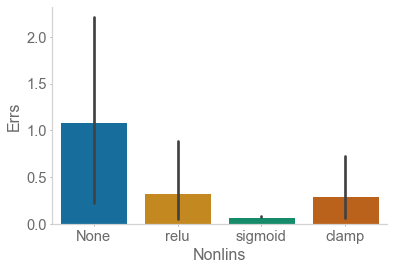

In [24]:
df = pd.DataFrame({'Nonlins': new_nonlins, 'Errs': new_errs})
sns.barplot(x='Nonlins', y='Errs', data=df)

In [25]:
nonlins = []
errs = []
gamma = 0.8
for nonlinearity in [None, 'relu', 'sigmoid', 'clamp']:                                                                                                                                                         
    gamma_dir = f'{experiment_dir}{nonlinearity}/{gamma}/'                                               
    best_iter_val = np.inf                                                                               
    best_iter = None          
    for _iter in os.listdir(gamma_dir):                                                                  
        iter_dir = f'{gamma_dir}{_iter}/'
        _errs = run(iter_dir)
        errs.extend(_errs)
        nonlins.extend([nonlinearity]*len(_errs))

/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [30]:
new_nonlins = []
new_errs = []
for n, e in zip(nonlins, errs):
    if e > 10:
        continue
    if n is None:
        new_nonlins.append('None')
    else:
        new_nonlins.append(n)
    new_errs.append(e)

<AxesSubplot:xlabel='Nonlins', ylabel='Errs'>

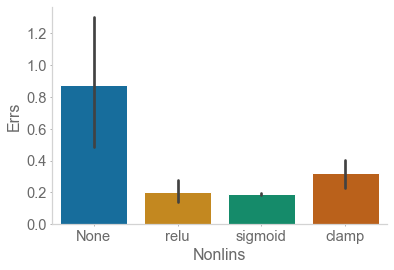

In [31]:
df = pd.DataFrame({'Nonlins': new_nonlins, 'Errs': new_errs})
sns.barplot(x='Nonlins', y='Errs', data=df)